#Analysis on Features Chosen Through Stepwise Regression Technique

# Importing Packages and Prepared Data

Two datasets were created: One where the target is split into five classes, and one where it is split into three. Both are loaded and both will undergo the same model testing.

In [1]:
import numpy as np
from numpy import mean, std
from scipy.stats import sem
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
stepwise_df_5 = pd.read_csv("/content/gdrive/MyDrive/stepwise_df_5.csv")
stepwise_df_3 = pd.read_csv("/content/gdrive/MyDrive/stepwise_df_3.csv")

# Decision Tree Classifiers

In [3]:
#Splitting the dataset into targets and features.
features_5 = stepwise_df_5.iloc[:, :-1]
target_5 = stepwise_df_5.iloc[:, -1]

In [4]:
#Splitting the model into 80% training data and 20% testing data.
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(features_5, target_5, test_size=0.2,random_state=109)

In [5]:
#Initializing the Decision Tree Classifier.
clf_5 = tree.DecisionTreeClassifier()

In [6]:
#I am first testing the model on the training and test data to see initial results. f1 score is 0.38 and the Matthews correlation coefficient is 0.31
#I can see that the 'Very Low' class is over-represented in my samples, and the model performs better across all metrics when predicting this class.
clf_5.fit(X_train_5, y_train_5)
y_pred_5 = clf_5.predict(X_test_5)
print(classification_report(y_test_5, y_pred_5))
print('Matthews:',matthews_corrcoef(y_test_5, y_pred_5))

              precision    recall  f1-score   support

        High       0.20      0.14      0.17        21
         Low       0.35      0.37      0.36        92
      Medium       0.15      0.23      0.18        31
   Very High       0.67      0.40      0.50        15
    Very Low       0.81      0.78      0.80       240

    accuracy                           0.60       399
   macro avg       0.44      0.38      0.40       399
weighted avg       0.62      0.60      0.60       399

Matthews: 0.30899627469609264


Cross-Validating The Model

I used  two cross-validation methods: RepeatedKFold validation and StratifiedKFold validation. I chose to use both as I can see from my initial test that one class is over-represented in the data, which means that stratified sampling for cross-validation could be effective in improving the performance of the model.

In [7]:
#Initializing the model for stratified KFold cross-validation.
clf_sk_5 = tree.DecisionTreeClassifier()

>1 f1=0.3938 se=0.011
>2 f1=0.4008 se=0.006
>3 f1=0.3866 se=0.007
>4 f1=0.3835 se=0.006
>5 f1=0.3893 se=0.006
>6 f1=0.3859 se=0.005
>7 f1=0.3826 se=0.005
>8 f1=0.3845 se=0.005
>9 f1=0.3857 se=0.004
>10 f1=0.3837 se=0.004
>11 f1=0.3842 se=0.004
>12 f1=0.3854 se=0.004
>13 f1=0.3835 se=0.004
>14 f1=0.3838 se=0.003
>15 f1=0.3833 se=0.003


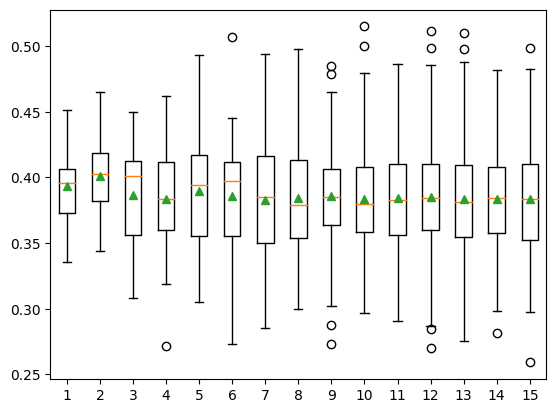

In [8]:
#Executing a loop to determine the amount of repeats that will optimize the model. I am basing the optimization on the f1 score rather than the accuracy because
#precision and recall are metrics I want to consider in my evaluation, and accuracy does not give a full picture of the model's performance, especially in a skewed
#dataset.
#Based on the boxplot, 14 repeats with 10 splits is the most stable model because the median (orange line) and the mean (green triangle) are closely aligned, which
#indicates symmetrically distributed data.
#There are no outliers, the standard error is low at 0.004, and the f1 score is only slightly lower than the highest achieved by the model.
def evaluate_model(X, y, repeats):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = tree.DecisionTreeClassifier()
 scores_clf_5 = cross_val_score(model, features_5, target_5, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_clf_5
repeats = range(1,16)
results_clf_5 = list()
for r in repeats:
 scores_clf_5 = evaluate_model(features_5, target_5, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_clf_5), sem(scores_clf_5)))
 results_clf_5.append(scores_clf_5)

plt.boxplot(results_clf_5, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [9]:
#Running the Repeated Stratified K Fold validation. The f1 score has not increased significantly based on the cross-validation, nor has the MCC score,
#which indicates that the model is stable across all folds despite the class imbalance.
skf_5 = RepeatedStratifiedKFold(n_splits=10, n_repeats=14, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf_5.split(features_5, target_5):
    x_train_fold, x_test_fold = features_5.iloc[train_index], features_5.iloc[test_index]
    y_train_fold, y_test_fold = target_5[train_index], target_5[test_index]
    clf_sk_5.fit(x_train_fold, y_train_fold)
    y_pred = clf_sk_5.predict(x_test_fold)
    lst_accu_stratified.append(clf_sk_5.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy that can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', std(lst_accu_stratified))
scores = cross_val_score(clf_sk_5, features_5, target_5, scoring='f1_macro', cv=skf_5, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores), std(scores)))
scores_matthews = cross_val_score(clf_sk_5, features_5, target_5, scoring='matthews_corrcoef', cv=skf_5, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

List of possible accuracy: [0.625, 0.635, 0.665, 0.595, 0.6432160804020101, 0.6231155778894473, 0.6130653266331658, 0.6331658291457286, 0.6180904522613065, 0.5879396984924623, 0.635, 0.67, 0.59, 0.625, 0.6482412060301508, 0.5879396984924623, 0.6080402010050251, 0.6331658291457286, 0.6231155778894473, 0.6130653266331658, 0.555, 0.6, 0.615, 0.625, 0.592964824120603, 0.5678391959798995, 0.5829145728643216, 0.592964824120603, 0.6030150753768844, 0.6080402010050251, 0.57, 0.625, 0.625, 0.63, 0.5829145728643216, 0.5577889447236181, 0.6231155778894473, 0.6030150753768844, 0.6080402010050251, 0.6331658291457286, 0.62, 0.61, 0.615, 0.64, 0.5879396984924623, 0.6180904522613065, 0.5979899497487438, 0.6030150753768844, 0.6180904522613065, 0.5979899497487438, 0.585, 0.625, 0.58, 0.595, 0.6331658291457286, 0.6180904522613065, 0.6231155778894473, 0.5628140703517588, 0.6381909547738693, 0.5678391959798995, 0.58, 0.605, 0.6, 0.62, 0.6381909547738693, 0.6130653266331658, 0.5879396984924623, 0.6381909547

>1 f1=0.3849 se=0.016
>2 f1=0.3838 se=0.009
>3 f1=0.3851 se=0.009
>4 f1=0.3818 se=0.009
>5 f1=0.3781 se=0.007
>6 f1=0.3758 se=0.006
>7 f1=0.3745 se=0.005
>8 f1=0.3818 se=0.005
>9 f1=0.3767 se=0.005
>10 f1=0.3766 se=0.005
>11 f1=0.3758 se=0.004
>12 f1=0.3805 se=0.004
>13 f1=0.3812 se=0.004
>14 f1=0.3786 se=0.004
>15 f1=0.3757 se=0.004


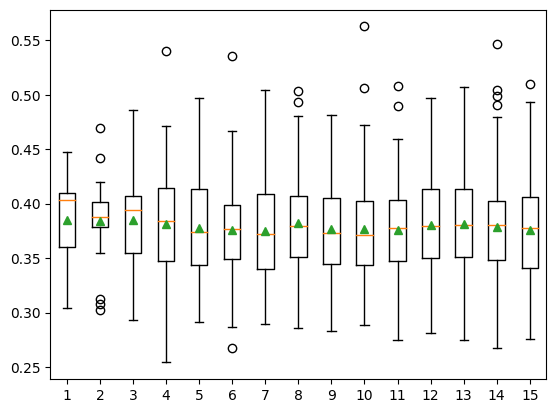

In [10]:
#I am also running the loop on the RepeatedKFold model to determine the number of optimal repeats. Here 13 repeats is the most optimal choice. Again, the
#mean and the median are closely aligned, there are no outliers, and the standard deviation is low at 0.004.
def evaluate_model(X, y, repeats):
 cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = tree.DecisionTreeClassifier()
 scores_clf_5 = cross_val_score(model, features_5, target_5, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_clf_5
repeats = range(1,16)
results_clf_5 = list()
for r in repeats:
 scores_clf_5 = evaluate_model(features_5, target_5, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_clf_5), sem(scores_clf_5)))
 results_clf_5.append(scores_clf_5)

plt.boxplot(results_clf_5, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [11]:
#With the optimizied repeats, the model averaged an f1 score of 0.378 and a MCC score of 0.32 which is about the same as the Stratified K-Fold and the initial test,
#indicating that the model is stable and could be trained with or without cross-validation.
cv_5 = RepeatedKFold(n_splits=10, n_repeats=13, random_state=1)
acc_scores = cross_val_score(clf_5, features_5, target_5, scoring='accuracy', cv=cv_5, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(acc_scores), std(acc_scores)))
scores_f1 = cross_val_score(clf_5, features_5, target_5, scoring='f1_macro', cv=cv_5, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(clf_5, features_5, target_5, scoring='matthews_corrcoef', cv=cv_5, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

Accuracy: 0.600 (0.038)
F1: 0.378 (0.048)
Matthews: 0.326 (0.052)


Repeating with 3 class dataset

In [12]:
features_3 = stepwise_df_3.iloc[:, :-1]
target_3 = stepwise_df_3.iloc[:, -1]

In [13]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features_3, target_3, test_size=0.2,random_state=109)

In [14]:
clf_3 = tree.DecisionTreeClassifier()

In [15]:
#Initial testing already shows improvement on f1 score, which has increased to 0.52, however the Matthews Correlation Coefficient is significantly lowoer at 0.34,
#indicating that the f1 score may not be indicative of the model's true performance.
clf_3.fit(X_train_3, y_train_3)
y_pred_3 = clf_3.predict(X_test_3)
print(classification_report(y_test_3, y_pred_3))
print('Matthews:',matthews_corrcoef(y_test_3, y_pred_3))

              precision    recall  f1-score   support

        High       0.50      0.55      0.52        67
         Low       0.82      0.82      0.82       270
      Medium       0.28      0.26      0.27        62

    accuracy                           0.69       399
   macro avg       0.54      0.54      0.54       399
weighted avg       0.69      0.69      0.69       399

Matthews: 0.36360964813442986


In [16]:
clf_sk_3 = tree.DecisionTreeClassifier()

>1 f1=0.5410 se=0.011
>2 f1=0.5509 se=0.008
>3 f1=0.5413 se=0.005
>4 f1=0.5469 se=0.006
>5 f1=0.5487 se=0.005
>6 f1=0.5456 se=0.005
>7 f1=0.5495 se=0.004
>8 f1=0.5516 se=0.004
>9 f1=0.5535 se=0.004
>10 f1=0.5508 se=0.004
>11 f1=0.5524 se=0.004
>12 f1=0.5508 se=0.003
>13 f1=0.5497 se=0.003
>14 f1=0.5496 se=0.003
>15 f1=0.5494 se=0.003


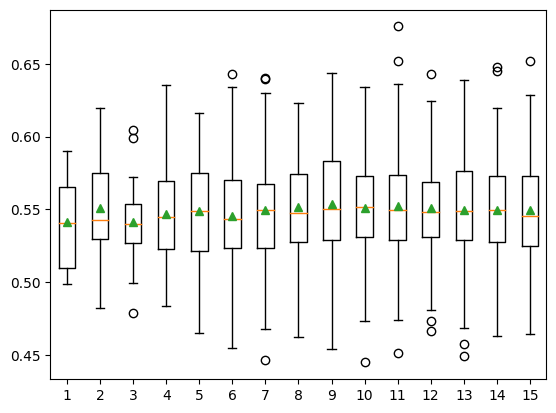

In [17]:
#Based on the boxplot, 5 repeats seems to be the optimal number for this model. Though other repeats have a slightly lower standard of error, 5 repeats is the
#only choice with a symmetric distribution and without a large number of outliers.
def evaluate_model(X, y, repeats):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = tree.DecisionTreeClassifier()
 scores_clf_3 = cross_val_score(model, features_3, target_3, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_clf_3
repeats = range(1,16)
results_clf_3 = list()
for r in repeats:
 scores_clf_3 = evaluate_model(features_3, target_3, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_clf_3), sem(scores_clf_3)))
 results_clf_3.append(scores_clf_3)

plt.boxplot(results_clf_3, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [18]:
#After Stratified K Fold, the average f1 score has increased slightly to 0.54 from 0.52. However, the MCC still falls behind at 0.39, though the gap is closed
#slightly by the model.
skf_3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf_3.split(features_3, target_3):
    x_train_fold, x_test_fold = features_3.iloc[train_index], features_3.iloc[test_index]
    y_train_fold, y_test_fold = target_3[train_index], target_3[test_index]
    clf_sk_3.fit(x_train_fold, y_train_fold)
    y_pred = clf_sk_3.predict(x_test_fold)
    lst_accu_stratified.append(clf_sk_3.score(x_test_fold, y_test_fold))

print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', std(lst_accu_stratified))
scores = cross_val_score(clf_sk_3, features_3, target_3, scoring='f1_macro', cv=skf_3, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores), std(scores)))
scores_matthews = cross_val_score(clf_sk_3, features_3, target_3, scoring='matthews_corrcoef', cv=skf_3, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))


Maximum Accuracy That can be obtained from this model is: 75.37688442211056 %

Minimum Accuracy: 65.32663316582915 %

Overall Accuracy: 69.31854271356784 %

Standard Deviation is: 0.023227263665342897
F1: 0.549 (0.032)
Matthews: 0.384 (0.050)


>1 f1=0.5649 se=0.018
>2 f1=0.5599 se=0.010
>3 f1=0.5549 se=0.007
>4 f1=0.5519 se=0.007
>5 f1=0.5537 se=0.005
>6 f1=0.5491 se=0.005
>7 f1=0.5436 se=0.005
>8 f1=0.5456 se=0.004
>9 f1=0.5497 se=0.004
>10 f1=0.5485 se=0.004
>11 f1=0.5468 se=0.003
>12 f1=0.5468 se=0.003
>13 f1=0.5447 se=0.003
>14 f1=0.5507 se=0.003
>15 f1=0.5503 se=0.003


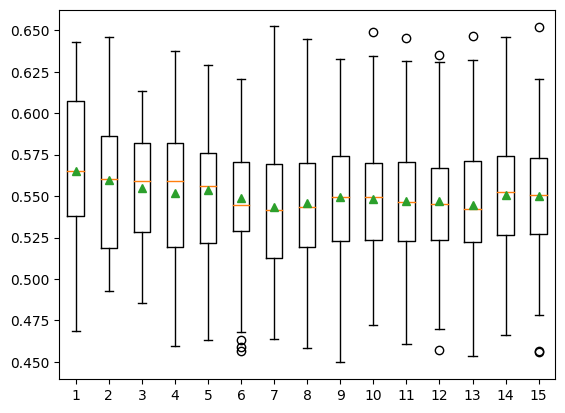

In [19]:
#Repeating with the Repeated K Fold cross-validation method. 14 repeats appears to be optimal. While both 4 and 14 show symmetric distributions without outliers,
#14 has a much smaller standard of error without sacrificing much on f1 score.
def evaluate_model(X, y, repeats):
 cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = tree.DecisionTreeClassifier()
 scores_clf_3 = cross_val_score(model, features_3, target_3, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_clf_3
repeats = range(1,16)
results_clf_3 = list()
for r in repeats:
 scores_clf_3 = evaluate_model(features_3, target_3, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_clf_3), sem(scores_clf_3)))
 results_clf_3.append(scores_clf_3)

plt.boxplot(results_clf_3, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [20]:
cv_3 = RepeatedKFold(n_splits=10, n_repeats=14, random_state=1)

In [21]:
#F1 score has remained fairly stable across all three models, with the RepeatedKFold performing the best at 0.55. However, the MCC score still falls behind the f1
#score, indicating that the model is not performing as well on negative predictions as it is on positive predictions. Cross-validation should be used to train
#the Decision Tree model in this case to close the gap between f1 and MCC slightly.
acc_scores = cross_val_score(clf_3, features_3, target_3, scoring='accuracy', cv=cv_3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(acc_scores), std(acc_scores)))
scores = cross_val_score(clf_3, features_3, target_3, scoring='f1_macro', cv=cv_3, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores), std(scores)))
scores_matthews = cross_val_score(clf_3, features_3, target_3, scoring='matthews_corrcoef', cv=cv_3, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

Accuracy: 0.699 (0.029)
F1: 0.550 (0.036)
Matthews: 0.401 (0.053)


# Logistic Regression Models

I will train the logistic regression models in the same way, with both methods of cross-validation considered.

In [22]:
X_train_set_5, X_test_set_5, Y_train_set_5, Y_test_set_5 = train_test_split(features_5, target_5, train_size=0.8, random_state=25)

In [23]:
lr_model_5 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model_5.fit(X_train_set_5, Y_train_set_5)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [24]:
#Initial results show an f1 score of 0.41 and again demonstrates that 'Very Low' is overrepresented in the sample. f1 score and MCC score are very closely related
#indicating that the initial f1 score is an accurate representation of the model's performance.
y_pred_lr_5 = lr_model_5.predict(X_test_set_5)
print(classification_report(Y_test_set_5, y_pred_lr_5))
print('Matthews:',matthews_corrcoef(Y_test_set_5, y_pred_lr_5))

              precision    recall  f1-score   support

        High       0.25      0.04      0.06        28
         Low       0.41      0.34      0.37        91
      Medium       0.22      0.20      0.21        25
   Very High       0.55      0.60      0.57        20
    Very Low       0.79      0.93      0.85       235

    accuracy                           0.67       399
   macro avg       0.44      0.42      0.41       399
weighted avg       0.62      0.67      0.63       399

Matthews: 0.39956811327771175


In [25]:
lr_model_sk_5 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

>1 f1=0.4084 se=0.010
>2 f1=0.4111 se=0.009
>3 f1=0.4104 se=0.007
>4 f1=0.4063 se=0.006
>5 f1=0.4061 se=0.006
>6 f1=0.4047 se=0.005
>7 f1=0.4040 se=0.005
>8 f1=0.4030 se=0.005
>9 f1=0.4027 se=0.004
>10 f1=0.4021 se=0.004
>11 f1=0.4027 se=0.004
>12 f1=0.4033 se=0.004
>13 f1=0.4034 se=0.004
>14 f1=0.4036 se=0.003
>15 f1=0.4032 se=0.003


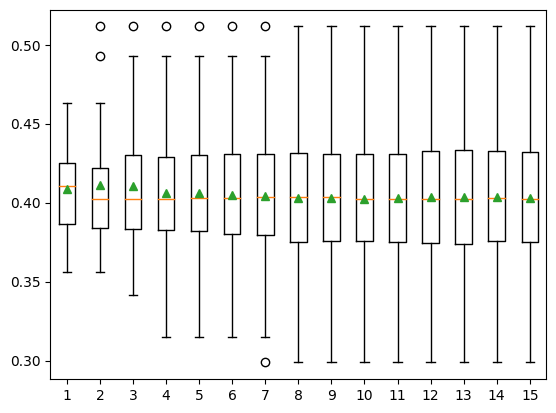

In [26]:
#Based on the boxplot, the model is most stable at 14 repeats. It is the most symmetrically distributed with the lowest standard of error.
#It is worth noting that this model is much less time efficient than the Decision Tree model,
#taking 7 minutes to execute vs 2 minutes.
def evaluate_model(X, y, repeats):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
 scores_lr_5 = cross_val_score(model, features_5, target_5, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_lr_5
repeats = range(1,16)
results_lr_5 = list()
for r in repeats:
 scores_lr_5 = evaluate_model(features_5, target_5, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_lr_5), sem(scores_lr_5)))
 results_lr_5.append(scores_lr_5)

plt.boxplot(results_lr_5, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [27]:
#In the Stratified K-Fold model, the average F1 score is almost the same as the initial result at 0.40, and while the MCC score has improved slightly, the
#two still remain closely related.
skf_lr_5 = RepeatedStratifiedKFold(n_splits=10, n_repeats=14, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf_lr_5.split(features_5, target_5):
    x_train_fold, x_test_fold = features_5.iloc[train_index], features_5.iloc[test_index]
    y_train_fold, y_test_fold = target_5[train_index], target_5[test_index]
    lr_model_sk_5.fit(x_train_fold, y_train_fold)
    y_pred = lr_model_sk_5.predict(x_test_fold)
    lst_accu_stratified.append(lr_model_sk_5.score(x_test_fold, y_test_fold))

print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', std(lst_accu_stratified))
scores = cross_val_score(lr_model_sk_5, features_5, target_5, scoring='f1_macro', cv=skf_lr_5, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores), std(scores)))
scores_matthews = cross_val_score(lr_model_sk_5, features_5, target_5, scoring='matthews_corrcoef', cv=skf_lr_5, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))


Maximum Accuracy That can be obtained from this model is: 75.0 %

Minimum Accuracy: 63.5 %

Overall Accuracy: 68.71782124910266 %

Standard Deviation is: 0.022938521378365304
F1: 0.404 (0.041)
Matthews: 0.430 (0.045)


>1 f1=0.3939 se=0.009
>2 f1=0.3907 se=0.009
>3 f1=0.3954 se=0.007
>4 f1=0.3963 se=0.006
>5 f1=0.3968 se=0.005
>6 f1=0.3961 se=0.005
>7 f1=0.3951 se=0.005
>8 f1=0.3962 se=0.004
>9 f1=0.3961 se=0.004
>10 f1=0.3957 se=0.004
>11 f1=0.3958 se=0.004
>12 f1=0.3959 se=0.004
>13 f1=0.3964 se=0.003
>14 f1=0.3972 se=0.003
>15 f1=0.3973 se=0.003


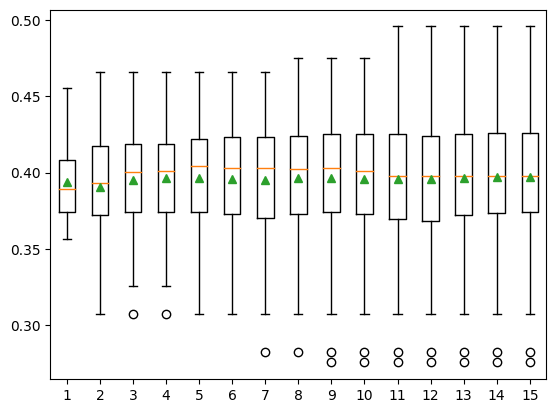

In [28]:
#I repeated the loop on the Repeated K-Fold cross-validation method. In this case, 15 repeats is the most optimal even though it has outliers, as it is the most
#symmetrically distributed and has a low standard of error without sacrificing the f1 score.
def evaluate_model(X, y, repeats):
 cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
 scores_lr_5 = cross_val_score(model, features_5, target_5, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_lr_5
repeats = range(1,16)
results_lr_5 = list()
for r in repeats:
 scores_lr_5 = evaluate_model(features_5, target_5, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_lr_5), sem(scores_lr_5)))
 results_lr_5.append(scores_lr_5)

plt.boxplot(results_lr_5, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [29]:
#The average f1 score for the Repeated K-fold cross-validation is 0.40 and the MCC score is 0.43,which is about the same as the initial test results and
#indicates the model is stable.
cv_5 = RepeatedKFold(n_splits=10, n_repeats=15, random_state=1)
acc_scores = cross_val_score(lr_model_5, features_5, target_5, scoring='accuracy', cv=cv_5, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(acc_scores), std(acc_scores)))
scores_f1 = cross_val_score(lr_model_5, features_5, target_5, scoring='f1_macro', cv=cv_5, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(lr_model_5, features_5, target_5, scoring='matthews_corrcoef', cv=cv_5, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

Accuracy: 0.687 (0.029)
F1: 0.397 (0.040)
Matthews: 0.431 (0.040)


Repeating with the 3 Class Dataset

In [30]:
X_train_set_3, X_test_set_3, Y_train_set_3, Y_test_set_3 = train_test_split(features_3, target_3, train_size=0.8, random_state=25)

In [31]:
lr_model_3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model_3.fit(X_train_set_3, Y_train_set_3)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [32]:
#The starting f1 score for the model using 3 classes in the target attribute is much higher than that with 5 at 0.60 compared to 0.41, and the MCC is closely
#related at 0.58
#'Low' is still overrepresented in the sample, and the model seems to struggle the most with recall on 'Medium'.
y_pred_lr_3 = lr_model_3.predict(X_test_set_3)
print(classification_report(Y_test_set_3, y_pred_3))
print('Matthews:',matthews_corrcoef(Y_test_set_3, y_pred_lr_3))

              precision    recall  f1-score   support

        High       0.11      0.11      0.11        73
         Low       0.64      0.65      0.64       265
      Medium       0.14      0.13      0.14        61

    accuracy                           0.47       399
   macro avg       0.30      0.30      0.30       399
weighted avg       0.47      0.47      0.47       399

Matthews: 0.5806331666648982


In [33]:
lr_model_sk_3 = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

>1 f1=0.5878 se=0.011
>2 f1=0.5875 se=0.008
>3 f1=0.5870 se=0.007
>4 f1=0.5897 se=0.006
>5 f1=0.5900 se=0.005
>6 f1=0.5900 se=0.005
>7 f1=0.5892 se=0.004
>8 f1=0.5886 se=0.004
>9 f1=0.5890 se=0.004
>10 f1=0.5890 se=0.004
>11 f1=0.5893 se=0.003
>12 f1=0.5892 se=0.003
>13 f1=0.5890 se=0.003
>14 f1=0.5892 se=0.003
>15 f1=0.5893 se=0.003


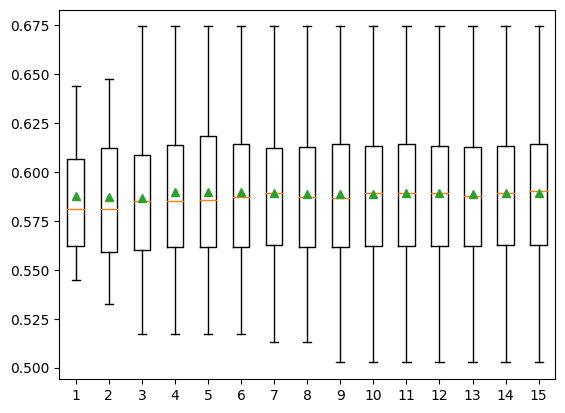

In [34]:
#Here 11 repeats is the most stable chocie with a symmetric distribution, a low standard of error, and an f1 score that is close to the highest achieved.
#Processing time still longer at 7mins.
def evaluate_model(X, y, repeats):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
 scores_lr_3 = cross_val_score(model, features_3, target_3, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_lr_3
repeats = range(1,16)
results_lr_3 = list()
for r in repeats:
 scores_lr_3 = evaluate_model(features_3, target_3, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_lr_3), sem(scores_lr_3)))
 results_lr_3.append(scores_lr_3)

plt.boxplot(results_lr_3, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [35]:
#The average f1 score on the Stratified K-fold cross-validation model is 0.589 which is close to the f1 score achieved before cross-validation, as is the MCC
#score at 0.56.
skf_lr_3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=11, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf_lr_3.split(features_3, target_3):
    x_train_fold, x_test_fold = features_3.iloc[train_index], features_3.iloc[test_index]
    y_train_fold, y_test_fold = target_3[train_index], target_3[test_index]
    lr_model_sk_3.fit(x_train_fold, y_train_fold)
    y_pred = lr_model_sk_3.predict(x_test_fold)
    lst_accu_stratified.append(lr_model_sk_3.score(x_test_fold, y_test_fold))

print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', std(lst_accu_stratified))
scores_f1 = cross_val_score(lr_model_sk_3, features_3, target_3, scoring='f1_macro', cv=skf_lr_3, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(lr_model_sk_3, features_3, target_3, scoring='matthews_corrcoef', cv=skf_lr_3, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))


Maximum Accuracy That can be obtained from this model is: 84.42211055276381 %

Minimum Accuracy: 75.5 %

Overall Accuracy: 79.8399497487437 %

Standard Deviation is: 0.019444565713432387
F1: 0.589 (0.036)
Matthews: 0.563 (0.047)


>1 f1=0.5880 se=0.018
>2 f1=0.5886 se=0.010
>3 f1=0.5868 se=0.008
>4 f1=0.5871 se=0.007
>5 f1=0.5879 se=0.006
>6 f1=0.5875 se=0.006
>7 f1=0.5874 se=0.005
>8 f1=0.5878 se=0.005
>9 f1=0.5880 se=0.004
>10 f1=0.5877 se=0.004
>11 f1=0.5879 se=0.004
>12 f1=0.5878 se=0.004
>13 f1=0.5877 se=0.003
>14 f1=0.5876 se=0.003
>15 f1=0.5875 se=0.003


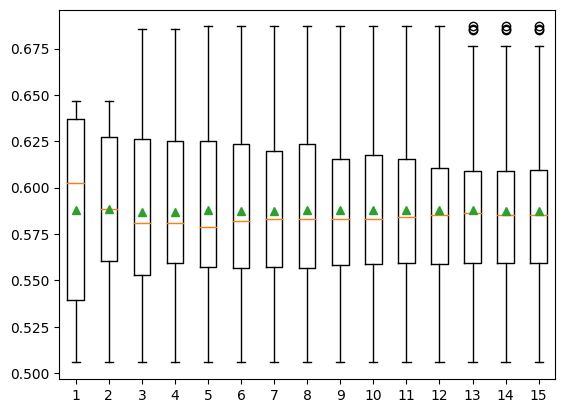

In [36]:
#Based on this model I would use 13 repeats at it is the most symmetrically distributed, and despite the outliers has a low standard of error.
def evaluate_model(X, y, repeats):
 cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
 scores_lr_3 = cross_val_score(model, features_3, target_3, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_lr_3
repeats = range(1,16)
results_lr_3 = list()
for r in repeats:
 scores_lr_3 = evaluate_model(features_3, target_3, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_lr_3), sem(scores_lr_3)))
 results_lr_3.append(scores_lr_3)

plt.boxplot(results_lr_3, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [37]:
#The f1 score for this model is 0.59 and the MCC score is 0.56 which again is close to the score given by the model before cross-validation.
#This indicates a stable model and demonstrates that this score is an accurate representation of the model's performance.
cv_3 = RepeatedKFold(n_splits=10, n_repeats=13, random_state=1)
acc_scores = cross_val_score(lr_model_3, features_3, target_3, scoring='accuracy', cv=cv_3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(acc_scores), std(acc_scores)))
scores_f1 = cross_val_score(lr_model_3, features_3, target_3, scoring='f1_macro', cv=cv_3, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(lr_model_3, features_3, target_3, scoring='matthews_corrcoef', cv=cv_3, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

Accuracy: 0.798 (0.026)
F1: 0.588 (0.039)
Matthews: 0.560 (0.053)


# KNN Nearest Neighbors Classifiers

In [38]:
#Splitting the data
x_train_5, x_test_5, Y_train_5, Y_test_5 = train_test_split(features_5, target_5, train_size = 0.8, random_state=42)

In [42]:
#K Nearest Neighbors classifiers also requires some preprocessing to determine the optimal number of neighbors to consider, which I implement here with a loop
#to determine the number of neighbors which both optimizes the f1 score and the MCC score. In this case, I will take the 6 neighbors because the MCC score can
#be more important to evaluating the model's performance.
f1 = []
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train_5,Y_train_5)
    yhat_5 = neigh.predict(x_test_5)
    f1.append(metrics.f1_score(Y_test_5, yhat_5, average='macro'))
print("Maximum f1:-",max(f1),"at K =",f1.index(max(f1)))

MCC = []
for i in range (1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train_5,Y_train_5)
    yhat_5 = neigh.predict(x_test_5)
    MCC.append(matthews_corrcoef(Y_test_5, yhat_5))
print("Maximum MCC:-",max(MCC),"at K =",MCC.index(max(MCC)))

Maximum f1:- 0.4097353668492005 at K = 5
Maximum MCC:- 0.42402414143259837 at K = 6


In [43]:
#The f1 score on initial testing is 0.41, and the MCC is similar at 0.42
#Again we see that 'Very Low' is overrepresented, and the model struggles with both precision and recall on all other classes.
classifier_5 = KNeighborsClassifier(n_neighbors=6)
classifier_5.fit(x_train_5, Y_train_5)
Y_pred_5 = classifier_5.predict(x_test_5)
print(classification_report(Y_test_5, Y_pred_5))
print('Matthews:',matthews_corrcoef(Y_test_5, Y_pred_5))

              precision    recall  f1-score   support

        High       0.30      0.19      0.23        16
         Low       0.40      0.47      0.43        72
      Medium       0.35      0.21      0.26        38
   Very High       0.40      0.18      0.25        11
    Very Low       0.85      0.90      0.88       262

    accuracy                           0.71       399
   macro avg       0.46      0.39      0.41       399
weighted avg       0.69      0.71      0.69       399

Matthews: 0.41777392284905246


In [44]:
classifier_sk_5 = KNeighborsClassifier(n_neighbors=6)

>1 f1=0.4027 se=0.015
>2 f1=0.4050 se=0.012
>3 f1=0.4025 se=0.010
>4 f1=0.4025 se=0.008
>5 f1=0.4035 se=0.007
>6 f1=0.4035 se=0.006
>7 f1=0.4030 se=0.006
>8 f1=0.4020 se=0.005
>9 f1=0.4027 se=0.005
>10 f1=0.4016 se=0.004
>11 f1=0.4038 se=0.004
>12 f1=0.4032 se=0.004
>13 f1=0.4018 se=0.004
>14 f1=0.4022 se=0.004
>15 f1=0.4033 se=0.004


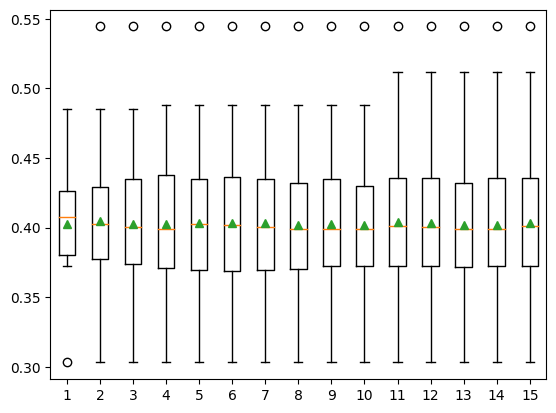

In [45]:
#Once again I will choose the number of repeats that results in the most symmetrically distributed data with the lowest standard of error
#without sacrificing f1 score, which in this case is 6 repeats.
def evaluate_model(X, y, repeats):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = KNeighborsClassifier(n_neighbors=6)
 scores_knn_5 = cross_val_score(model, features_5, target_5, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_knn_5
repeats = range(1,16)
results_knn_5 = list()
for r in repeats:
 scores_knn_5 = evaluate_model(features_5, target_5, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_knn_5), sem(scores_knn_5)))
 results_knn_5.append(scores_knn_5)

plt.boxplot(results_knn_5, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [46]:
#The average f1 score achieved by this model is 0.40, which is almost the same as our initial testing model and though the MCC score drops slightly to 0.39,
#it is still close to the f1 score and indicates that these two metrics are an accurate representation of the model's performance.
skf_knn_5 = RepeatedStratifiedKFold(n_splits=10, n_repeats=6, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf_knn_5.split(features_5, target_5):
    x_train_fold, x_test_fold = features_5.iloc[train_index], features_5.iloc[test_index]
    y_train_fold, y_test_fold = target_5[train_index], target_5[test_index]
    classifier_sk_5.fit(x_train_fold, y_train_fold)
    y_pred = classifier_sk_5.predict(x_test_fold)
    lst_accu_stratified.append(classifier_sk_5.score(x_test_fold, y_test_fold))

print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', std(lst_accu_stratified))
scores_f1 = cross_val_score(classifier_sk_5, features_5, target_5, scoring='f1_macro', cv=skf_knn_5, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(classifier_sk_5, features_5, target_5, scoring='matthews_corrcoef', cv=skf_knn_5, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))


Maximum Accuracy That can be obtained from this model is: 73.0 %

Minimum Accuracy: 60.5 %

Overall Accuracy: 65.42035175879397 %

Standard Deviation is: 0.02194358511050167
F1: 0.403 (0.048)
Matthews: 0.387 (0.040)


>1 f1=0.4060 se=0.013
>2 f1=0.4079 se=0.008
>3 f1=0.4029 se=0.008
>4 f1=0.4034 se=0.008
>5 f1=0.4017 se=0.007
>6 f1=0.3981 se=0.006
>7 f1=0.3993 se=0.006
>8 f1=0.3980 se=0.006
>9 f1=0.3974 se=0.005
>10 f1=0.3959 se=0.005
>11 f1=0.3972 se=0.005
>12 f1=0.3972 se=0.005
>13 f1=0.3960 se=0.005
>14 f1=0.3949 se=0.004
>15 f1=0.3954 se=0.004


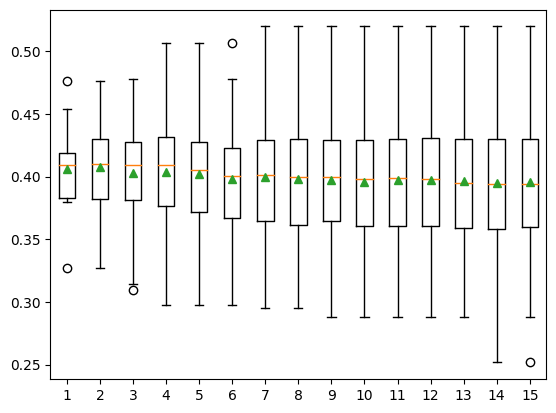

In [47]:
#For the Repeated K-fold model, the optimal number of repeats is 14 based on the distribution, the f1 score, and the low standard of error.
def evaluate_model(X, y, repeats):
 cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = KNeighborsClassifier(n_neighbors=6)
 scores_knn_5 = cross_val_score(model, features_5, target_5, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_knn_5
repeats = range(1,16)
results_knn_5 = list()
for r in repeats:
 scores_knn_5 = evaluate_model(features_5, target_5, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_knn_5), sem(scores_knn_5)))
 results_knn_5.append(scores_knn_5)

plt.boxplot(results_knn_5, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [48]:
#The average f1 score achieved by this model is 0.40 and the MCC is 0.39, which is once again very close to our initial test,
#which indicates that the model is stable.
cv_5 = RepeatedKFold(n_splits=10, n_repeats=14, random_state=1)
acc_scores = cross_val_score(classifier_5, features_5, target_5, scoring='accuracy', cv=cv_5, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(acc_scores), std(acc_scores)))
scores_f1 = cross_val_score(classifier_5, features_5, target_5, scoring='f1_macro', cv=cv_5, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(classifier_5, features_5, target_5, scoring='matthews_corrcoef', cv=cv_5, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

Accuracy: 0.654 (0.034)
F1: 0.395 (0.053)
Matthews: 0.386 (0.047)


Repeating with the 3 Class Dataset

In [49]:
#Repeating the KNN optimization process with the dataset that has 3 classes indicates that the optimal numebr of neighbors is 7.
x_train_3, x_test_3, Y_train_3, Y_test_3 = train_test_split(features_3, target_3, train_size = 0.8, random_state=42)
acc = []
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train_3,Y_train_3)
    yhat_3 = neigh.predict(x_test_3)
    acc.append(metrics.f1_score(Y_test_3, yhat_3, average='macro'))
print("Maximum f1:-",max(acc),"at K =",acc.index(max(acc)))
MCC = []
for i in range (1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train_3,Y_train_3)
    yhat_3 = neigh.predict(x_test_3)
    MCC.append(matthews_corrcoef(Y_test_3, yhat_3))
print("Maximum MCC:-",max(MCC),"at K =",MCC.index(max(MCC)))


Maximum f1:- 0.5960072197695959 at K = 7
Maximum MCC:- 0.5081705921737846 at K = 7


In [50]:
#Based on initial training and testing, the f1 score is 0.57, significantly better than the model with 5 classes. However, the MCC score falls behind at 0.48.
#Though 'Low' is still overrepresented, precision and recall metrics are improved for other classes.
classifier_3 = KNeighborsClassifier(n_neighbors=7)
classifier_3.fit(x_train_3, Y_train_3)

y_pred_3 = classifier_3.predict(x_test_3)
print(classification_report(Y_test_3, y_pred_3))
print('Matthews:',matthews_corrcoef(Y_test_3, y_pred_3))

              precision    recall  f1-score   support

        High       0.62      0.57      0.59        65
         Low       0.84      0.94      0.89       285
      Medium       0.42      0.16      0.24        49

    accuracy                           0.79       399
   macro avg       0.63      0.56      0.57       399
weighted avg       0.75      0.79      0.76       399

Matthews: 0.4764548029449716


In [51]:
classifier_sk_3 = KNeighborsClassifier(n_neighbors=7)

>1 f1=0.5762 se=0.013
>2 f1=0.5752 se=0.011
>3 f1=0.5803 se=0.008
>4 f1=0.5802 se=0.008
>5 f1=0.5802 se=0.007
>6 f1=0.5783 se=0.006
>7 f1=0.5791 se=0.005
>8 f1=0.5795 se=0.005
>9 f1=0.5805 se=0.004
>10 f1=0.5816 se=0.004
>11 f1=0.5820 se=0.004
>12 f1=0.5821 se=0.004
>13 f1=0.5821 se=0.003
>14 f1=0.5819 se=0.003
>15 f1=0.5818 se=0.003


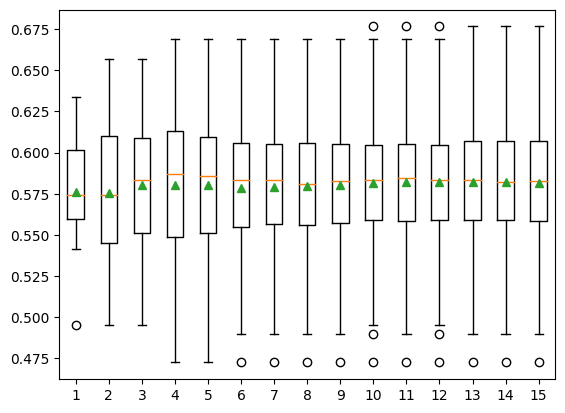

In [52]:
#Based on the boxplot for the Stratified K-fold model, I chose to use 14 repeats.
def evaluate_model(X, y, repeats):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = KNeighborsClassifier(n_neighbors=7)
 scores_knn_3 = cross_val_score(model, features_3, target_3, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_knn_3
repeats = range(1,16)
results_knn_3 = list()
for r in repeats:
 scores_knn_3 = evaluate_model(features_3, target_3, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_knn_3), sem(scores_knn_3)))
 results_knn_3.append(scores_knn_3)

plt.boxplot(results_knn_3, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [53]:
#The average f1 score with the Stratified K-fold model is 0.58, almost the same as the initial model. The MCC score has improved to 0.50, indicating that
#this cross-validation technique has improved the performance of the KNN model.
skf_knn_3 = RepeatedStratifiedKFold(n_splits=10, n_repeats=14, random_state=27)
lst_accu_stratified = []

for train_index, test_index in skf_knn_3.split(features_3, target_3):
    x_train_fold, x_test_fold = features_3.iloc[train_index], features_3.iloc[test_index]
    y_train_fold, y_test_fold = target_3[train_index], target_3[test_index]
    classifier_sk_3.fit(x_train_fold, y_train_fold)
    y_pred = classifier_sk_3.predict(x_test_fold)
    lst_accu_stratified.append(classifier_sk_3.score(x_test_fold, y_test_fold))

print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', std(lst_accu_stratified))
scores_f1 = cross_val_score(classifier_sk_3, features_3, target_3, scoring='f1_macro', cv=skf_knn_3, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(classifier_sk_3, features_3, target_3, scoring='matthews_corrcoef', cv=skf_knn_3, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))



Maximum Accuracy That can be obtained from this model is: 81.90954773869346 %

Minimum Accuracy: 71.85929648241206 %

Overall Accuracy: 76.92410265613783 %

Standard Deviation is: 0.02045004637800439
F1: 0.576 (0.039)
Matthews: 0.496 (0.049)


>1 f1=0.5774 se=0.012
>2 f1=0.5821 se=0.010
>3 f1=0.5782 se=0.007
>4 f1=0.5806 se=0.007
>5 f1=0.5806 se=0.007
>6 f1=0.5787 se=0.006
>7 f1=0.5800 se=0.005
>8 f1=0.5781 se=0.005
>9 f1=0.5775 se=0.004
>10 f1=0.5771 se=0.004
>11 f1=0.5778 se=0.004
>12 f1=0.5786 se=0.003
>13 f1=0.5778 se=0.003
>14 f1=0.5777 se=0.003
>15 f1=0.5778 se=0.003


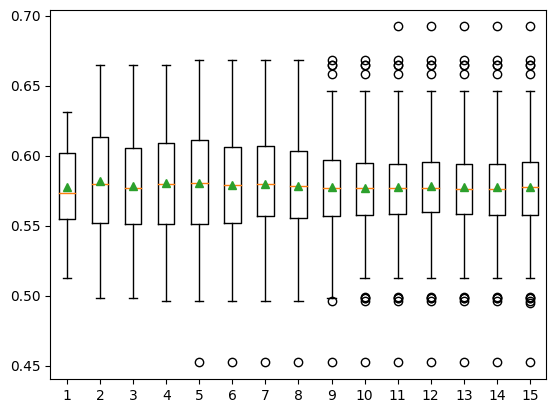

In [54]:
#In this case I chose 8 repeats because as repeats increase, though the data inside the IQR is fairly stable, there are too many outliers, while 8 repeats maintains
#a symmetrical distribution with few outliers, and a low standard of error.
def evaluate_model(X, y, repeats):
 cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
 model = KNeighborsClassifier(n_neighbors=7)
 scores_knn_3 = cross_val_score(model, features_3, target_3, scoring='f1_macro', cv=cv, n_jobs=-1)
 return scores_knn_3
repeats = range(1,16)
results_knn_3 = list()
for r in repeats:
 scores_knn_3 = evaluate_model(features_3, target_3, r)
 print('>%d f1=%.4f se=%.3f' % (r, mean(scores_knn_3), sem(scores_knn_3)))
 results_knn_3.append(scores_knn_3)

plt.boxplot(results_knn_3, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

In [55]:
#The f1 score remains stable at 0.58, as does the MCC score at 0.50. This indicates to me that cross-validation is essential to improving this model's performance
#on predicting both positive and negative values in each class.
cv_3 = RepeatedKFold(n_splits=10, n_repeats=8, random_state=1)
acc_scores = cross_val_score(classifier_3, features_3, target_3, scoring='accuracy', cv=cv_3, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(acc_scores), std(acc_scores)))
scores_f1 = cross_val_score(classifier_3, features_3, target_3, scoring='f1_macro', cv=cv_3, n_jobs=-1)
print('F1: %.3f (%.3f)' % (mean(scores_f1), std(scores_f1)))
scores_matthews = cross_val_score(classifier_3, features_3, target_3, scoring='matthews_corrcoef', cv=cv_3, n_jobs=-1)
print('Matthews: %.3f (%.3f)' % (mean(scores_matthews), std(scores_matthews)))

Accuracy: 0.770 (0.028)
F1: 0.578 (0.040)
Matthews: 0.496 (0.059)
